# Comparing Bandit Agents

This notebook compares the performance of different bandit agents.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os

from bart_playground.bandit.sim_util import *
from compare_agents import (
    compare_agents_across_scenarios, print_summary_results, plot_comparison_results
)
from bart_playground.bandit.rome.rome_scenarios import HomogeneousScenario, NonlinearScenario

In [ ]:
# Create test scenarios
scenarios = {
    "Linear": LinearScenario(P=4, K=2, sigma2=1.0),
    "LinearOffset": LinearOffsetScenario(P=4, K=2, sigma2=1.0),
    # "Offset": OffsetScenario(P=4, K=2, sigma2=1.0),
    "Friedman": FriedmanScenario(P=5, K=2, sigma2=1.0, lambda_val=5),
    "Friedman2": Friedman2Scenario(P=5, K=2, sigma2=1.0, lambda_val=0.5),
    # "Sparse": FriedmanScenario(P=25, K=2, sigma2=1.0, lambda_val=5),
    # "Sparse2": Friedman2Scenario(P=25, K=2, sigma2=1.0, lambda_val=1),
    "Homogeneous": HomogeneousScenario(),
    "Nonlinear": NonlinearScenario(),
}

np.random.seed(42)

In [ ]:
# Define experiment parameters
from bart_playground.bandit.bcf_agent import BCFAgent, BCFAgentPSOff
from bart_playground.bandit.basic_agents import SillyAgent, LinearTSAgent
from bart_playground.bandit.ensemble_agent import EnsembleAgent
from bart_playground.bandit.me_agents import HierTSAgent, LinearTSAgent2, LinearUCBAgent, METSAgent
# Import the ROME agents
from bart_playground.bandit.rome.rome_agent import RoMEAgent, _featurize
from bart_playground.bandit.rome.baseline_agents import StandardTSAgent, ActionCenteredTSAgent, IntelligentPoolingAgent

import multiprocessing

cores =  multiprocessing.cpu_count() - 1

n_simulations = 15  # Number of simulations per scenario
n_draws = 365      # Number of draws per simulation

def call_func():
    return(compare_agents_across_scenarios(
        scenarios=scenarios,
        n_simulations=n_simulations,
        n_draws=n_draws,
        agent_classes=[
        #    SillyAgent,
            LinearTSAgent,
            RoMEAgent,
            StandardTSAgent,
            ActionCenteredTSAgent, 
            IntelligentPoolingAgent,
            BCFAgent,
            EnsembleAgent
        ],
        agent_names=[
        #    "Random",
            "LinearTS",
            "RoME",
            "StandardTS",
            "ActionCenteredTS",
            "IntelligentPooling",
            "MBCF-TS (★)",
            "MBCF+Linear (▲)"
        ],
        n_jobs=cores, # min(n_simulations, cores),  # Use all available cores or the number of simulations, whichever is smaller
        batch_size=1
    ))

In [4]:
# %load_ext memory_profiler
# %mprun -f RoMEAgent.update_state call_func()

In [5]:
results = call_func()

Processing batch 1/1: scenarios 1-1 (16 jobs)


Simulating: 100%|██████████| 200/200 [01:13<00:00,  2.72it/s]


## Print Summary Results

Let's print a summary of the results for each scenario.

In [6]:
print_summary_results(results)


=== Nonlinear Scenario ===

Final cumulative regrets (mean ± std):
  LinearTS: 105.70 (±74.29)
  RoME: 122.42 (±78.63)
  StandardTS: 103.80 (±85.83)
  ActionCenteredTS: 170.68 (±104.96)
  IntelligentPooling: 91.12 (±67.20)
  MBCF-TS (★): 142.32 (±76.85)

Average computation times (seconds):
  LinearTS: 0.0265 (±0.0011)
  RoME: 3.0495 (±0.1776)
  StandardTS: 0.1130 (±0.0073)
  ActionCenteredTS: 0.0869 (±0.0038)
  IntelligentPooling: 1.3313 (±0.0756)
  MBCF-TS (★): 36.4339 (±2.7024)



## Visualize Results

Finally, let's visualize the cumulative regret for each agent across scenarios.

In [7]:
# Create results directory if it doesn't exist
results_dir = "./results/singlefinal2_nonsparse"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

import pickle

result_filename = os.path.join(results_dir, f"result.pkl")

In [8]:
with open(result_filename, "wb") as file:
    pickle.dump((results, n_draws), file)

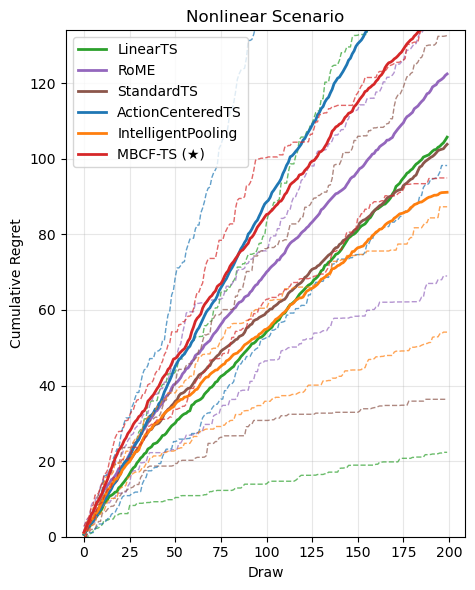

In [9]:
# import pickle
# results_dir = "./results/agent_comparison5"
# result_filename = os.path.join(results_dir, f"result.pkl")
results, n_draws = pickle.load(file=open(result_filename, "rb"))

# Plot results and save to file
plot_comparison_results(
    results=results,
    n_draws=n_draws,
    save_path=f"{results_dir}/agent_comparison_results.png",
    show_time=False
)